# Total variation

$$
TV(m) = || \nabla m ||_2^1 = \sum_{i=1}^{N_x N_z} \sqrt{(m_x)_i^2 + (m_z)_i^2}
$$

where $\nabla: \mathbb{R}^{N_x N_z} \to \mathbb{R}^{2 \times N_x N_z}$

Lets load up a survey



  TensorMesh: 4,558 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    106    -10,680.98     10,680.98     25.00  3,243.66    1.50
   y     43    -10,418.48         12.50     25.00  3,243.66    1.50




/tmp/ipykernel_101618/1569553183.py:79: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  mm1 = mesh.plotImage(res_true, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})
/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/discretize/utils/code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)
/tmp/ipykernel_101618/1569553183.py:87: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  mm = meshCore.plot_image(


adding dipole size: 25
adding dipole size: 50
adding dipole size: 75
adding dipole size: 100
adding dipole size: 125
adding dipole size: 150
adding dipole size: 175
adding dipole size: 200
adding dipole size: 225
0.011515031831853687
720.7073399801593
(3164,)


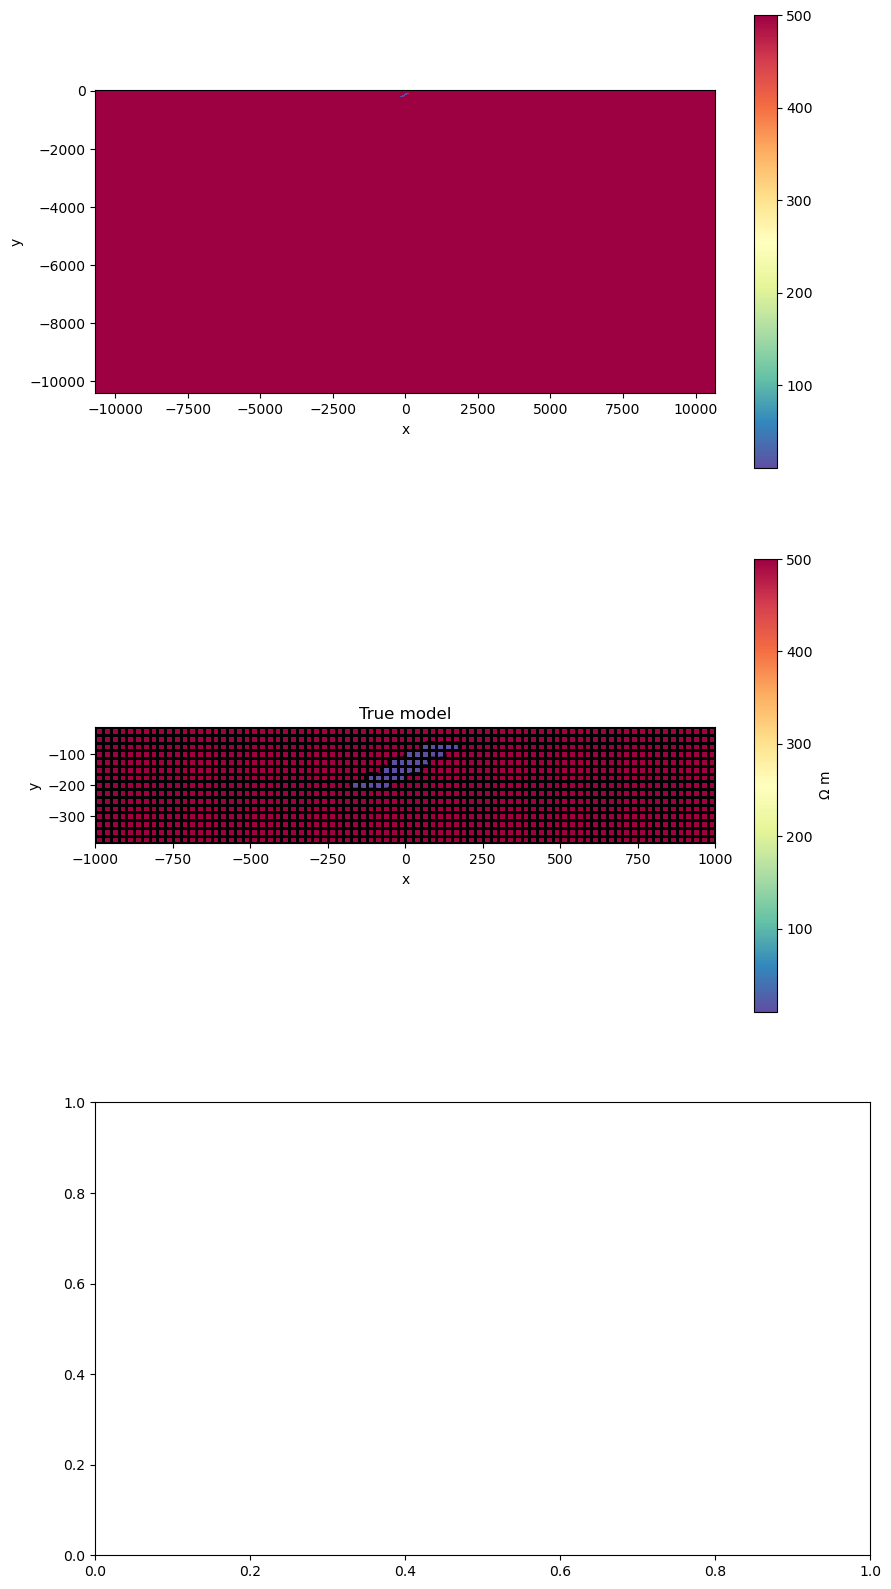

In [1]:
import geological_segmentation as geoseg
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from SimPEG.electromagnetics.static import resistivity as dc, utils as dcutils
import scipy.sparse as sp

# -------------------------------------------------------------------------------------------------

# create a 2d mesh for a dc simulation

#

#2D mesh
csx,  csy,  csz = 25,  25,  25
# Number of core cells in each direction
ncx,  ncz = int(162/2 + 1),  int(60/2 + 1)
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

print(mesh)

# -----------------------------------------------------------------------

# create a synthetic model for a dc simulation

#

model = 3 * np.ones(mesh.nC, dtype='int64')

# divide domain by  45* fault at 100 m
fault_function = lambda x, slope, shift: slope * x + shift

# Dike 30*
dike0 = mesh.gridCC[:,1] > fault_function(
    mesh.gridCC[:,0], np.tan(30 * np.pi / 180), -175)
dike1 = mesh.gridCC[:,1] < fault_function(
    mesh.gridCC[:,0], np.tan(30 * np.pi / 180), -100)
dike = np.logical_and(dike0,dike1)

model[dike]=4


# define conductivities
res_true = np.ones(mesh.nC)
res_true[model==3]= 500
res_true[model==4]= 10

index_deep = mesh.gridCC[:, 1] >= -50

index_deeper = mesh.gridCC[:, 1] < -200

res_true[index_deep] = 500
res_true[index_deeper] = 500

cond_true = 1./res_true

mtrue = np.log(cond_true)

xmin, xmax = -1000., 1000.
ymin, ymax = -400., 0.
zmin, zmax = 0, 0
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = utils.mesh_utils.extract_core_mesh(xyzlim, mesh)
actind = np.ones(mesh.n_cells, dtype=bool)

# plot
fig,ax = plt.subplots(3, 1,figsize=(10,20))
mm1 = mesh.plotImage(res_true, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})

# ax[0].set_xlim([-1000,1000])
# ax[0].set_ylim([-250,0])
ax[0].set_aspect(1)
plt.colorbar(mm1[0])

# plot
mm = meshCore.plot_image(
    
    1/(cond_true)[actcore],
    ax=ax[1],
    pcolorOpts={'cmap':'Spectral_r'},
    grid=True

)

utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[1],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)
# plt.gca().set_ylim([-200,0])
ax[1].set_aspect(1)
plt.colorbar(mm[0], label=r'$\Omega$ m')
ax[1].set_title('True model')

xmin, xmax = -750., 750.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
srclist = []

for dipole in np.arange(25,250,25):

    print(f'adding dipole size: {dipole}')
    
    survey1 = dcutils.generate_dcip_survey(
        
        endl, survey_type="pole-dipole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )

    # print(dipole)

    survey2 = dcutils.generate_dcip_survey(
        
        endl, survey_type="dipole-pole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )
    
    srclist +=(survey1.source_list)
    srclist +=(survey2.source_list)

survey = dc.Survey(srclist)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    
    mesh=mesh,
    indActive=actind,
    valInactive=np.log(1e-8)

)
mapping = expmap * mapactive
simulation = dc.Simulation2DNodal(
    
    mesh, 
    survey=survey, 
    sigmaMap=mapping,
    solver=Solver,
    nky=8

)

# -----------------------------------------------------------------------

# create synthetic data and view psuedo-section

#

relative_measurement_error = 0.01
dc_data = simulation.make_synthetic_data(
    
    mtrue,
    relative_error=relative_measurement_error,
    noise_floor=6e-3,
    force=True,
    add_noise=True,

)

# dc_data.noise_floor = np.quantile(np.abs(dc_data.dobs), 0.1)

relative_error_list = (np.abs(dc_data.standard_deviation/dc_data.dobs))
print(relative_error_list.min())
print(relative_error_list.max())
print(dc_data.dobs.shape)


# -----------------------------------------------------------------------

dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)



## evauate the total variation equation

In [8]:
G = mesh.cell_gradient
W = (
    sp.diags(mesh.cell_volumes**2) * mesh.average_face_to_cell
)
eps = 1e-8

v2 = mesh.cell_volumes**2
g2 = 0
g_m = G @ mtrue
g2 += g_m**2
W_g = W @ g2
sq = np.sqrt(W_g + eps * v2)
reg_tv = np.sum(sq)

## now the gradient

(9265, 4558) 4558 (4558, 9265) 25437.049038601683 (4558,)


/tmp/ipykernel_101618/3956053526.py:15: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  meshCore.plot_image((grad_tv)[actcore], ax=ax, pcolorOpts={'cmap':'Spectral_r'})


Text(0.5, 1.0, 'Gradient of TV')

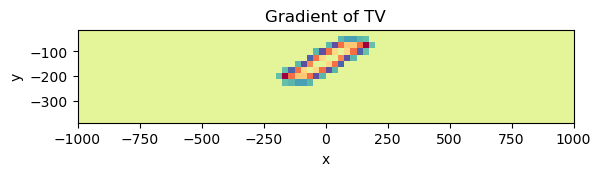

In [16]:

g2 = 0
v2 = mesh.cell_volumes**2
g_mi = G @ mtrue
g2 += g_mi**2
gs = g_mi
W_g = W @ g2
sq = np.sqrt(W_g + eps * v2)
mid = W.T @ (1 / sq)
ps = []
grad_tv = G.T @ (mid * g_mi)

print(G.shape, mesh.n_cells, W.shape, reg_tv, grad_tv.shape)

figure, ax = plt.subplots(1,1)
meshCore.plot_image((grad_tv)[actcore], ax=ax, pcolorOpts={'cmap':'Spectral_r'})
ax.set_aspect(1)
ax.set_title('Gradient of TV')

## second derivatives

In [19]:
v2 = mesh.cell_volumes**2
gs = []
g2 = 0
v = None

g_m = G @ mtrue
g2 += g_m**2
gs = g_m

W_g = W @ g2
sq = np.sqrt(W_g + eps * v2)
mid = W.T @ (1 / sq)

if v is not None:
    g_vs = []
    tmp_sum = 0
    # for vi, g_i in zip(self.wire_map * v, gs):
    g_vi = G @ (mtrue * v)
    tmp_sum += W.T @ ((W @ (gs * g_vi)) / sq**3)

    ps = (G.T @ (mid * g_vi - gs * tmp_sum))

else:
    Pieces = []
    Diags = []
    SQ = sp.diags(sq**-1.5)
    diag_block = G.T @ sp.diags(mid) @ G
    Pieces = SQ @ W @ sp.diags(gs) @ G
    Diags = diag_block
    Row = Pieces
    # Diag = sp.block_diag(Diags, format="csr")
    ps = Diags - Row.T @ Row

In [20]:
ps

<4558x4558 sparse matrix of type '<class 'numpy.float64'>'
	with 22548 stored elements in Compressed Sparse Column format>